In [42]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import SymLogNorm
import scienceplots


import astropy.units as u
from astropy import constants
from astropy.table import Table
from astropy.coordinates import SkyCoord,FK5,ICRS
from astropy.io import fits,ascii
from astropy.wcs import WCS, utils as wcsutils
from astropy.stats import sigma_clipped_stats
import astropy.visualization as vis
from astropy.cosmology import Planck18
from astropy.modeling import models, fitting
from astropy.nddata import StdDevUncertainty, Cutout2D
from astropy.convolution import Gaussian2DKernel,Gaussian1DKernel

from scipy.signal import find_peaks


from specutils import Spectrum1D, SpectralRegion
from specutils.fitting import estimate_line_parameters,fit_lines,find_lines_threshold
from specutils.manipulation import extract_region

from photutils.aperture import EllipticalAperture, SkyEllipticalAperture

import os, sys, glob, pdb

from importlib import reload
import pyregion as pyreg
from spectral_cube import SpectralCube
from reproject import reproject_interp
from regions import Regions
import linetools
import glob

from frb.frb import FRB
from frb.analysis import kcwi
brightu = r"Brightness $\rm (10^{-4}~erg~s^{-1}~arcsec^{-2}~cm^{-2}~\AA^{-1})$"
def imshow_astro(img, wcsinfo = None, figsize = (10,10), colorbar =True,
               cblabel="", cbfrac = 0.035, norm = None,
               stretch = vis.LinearStretch(), cmap = "hot",
               vrange = (None, None)):
    
    _, med, std = sigma_clipped_stats(img.data)
    
    fig =  plt.figure(figsize = figsize)
    if wcsinfo:
        ax = plt.subplot(projection = wcsinfo)
    else:
        ax = plt.subplot()
    
    vmin, vmax = vrange
    
    if not vmin:
        vmin = med
    if not vmax:
        vmax = med + 10*std
    if not norm:
        norm = vis.ImageNormalize(vmin = vmin, vmax = vmax, stretch = stretch)
    im = ax.imshow(img, norm = norm, cmap = cmap)
    if colorbar:
        cb = plt.colorbar(im, label = cblabel, fraction =cbfrac)
    return fig, ax, im
KBSSpath="/disk/bifrost/yuanze/KBSS"
#cubename="Q01"
sourcename="QSO-E"
psname="MD17"

lesslines={"[S II]":[6731.] ,'[O III]':[5007],'[O II]':[3727], r"H$\alpha$":[6563], r"H$\beta$":[4861.]}
lines={'[N II]':[6548.,6583.],"[S II]":[6716.,6731.] ,'[O III]':[4959,5007],'[O II]':[3727], r"H$\alpha$":[6563], r"H$\beta$":[4861.],r"Fe II":[6491.28,6385.45,6598.3]}

qsos = ascii.read(KBSSpath+"/KCWI/qsos.kcwi",format="ipac")
sentry=qsos[qsos["Name"]==psname]
field=sentry["Field"].value[0]

if sentry["zneb"]>0:
    redshift=sentry["zneb"].value[0]
elif sentry["zabs"]>0:
    redshift=sentry["zabs"].value[0]
else:
    redshift=sentry["zlya"].value[0]
RA = sentry["RA"].value[0]
DEC = sentry["Dec"].value[0]

datapath=KBSSpath+"/"+field+"/"+sourcename
subdapath=KBSSpath+"/"+field+"/"+psname

# LRIS

In [43]:

if len(glob.glob(subdapath+"/spec/*lris.trim*fits"))!=0:
    lrisdata=glob.glob(subdapath+"/spec/*lris.trim*fits")[0]
elif len(glob.glob(subdapath+"/spec/*lris.flx.fits"))!=0:
    lrisdata=glob.glob(subdapath+"/spec/*lris.flx.fits")[0]
elif len(glob.glob(subdapath+"/spec/*lris.fits"))!=0:
    lrisdata=glob.glob(subdapath+"/spec/*lris.fits")[0]

lris1d = fits.open(lrisdata)

lris1d[0].header['CRVAL1']
spec_axis = lris1d[0].header["CRVAL1"]+ (np.arange(lris1d[0].data.shape[0])+1-lris1d[0].header["CRPIX1"])*lris1d[0].header["CD1_1"]
flux_1d = lris1d[0].data
#mask_lris = np.abs(lris1d[0].data[2]) < 0.1

In [44]:
lris1d.info()

Filename: /disk/bifrost/yuanze/KBSS/Q1549/MD17/spec/Q1549-MD17.lris.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     179   (2253,)   float32   


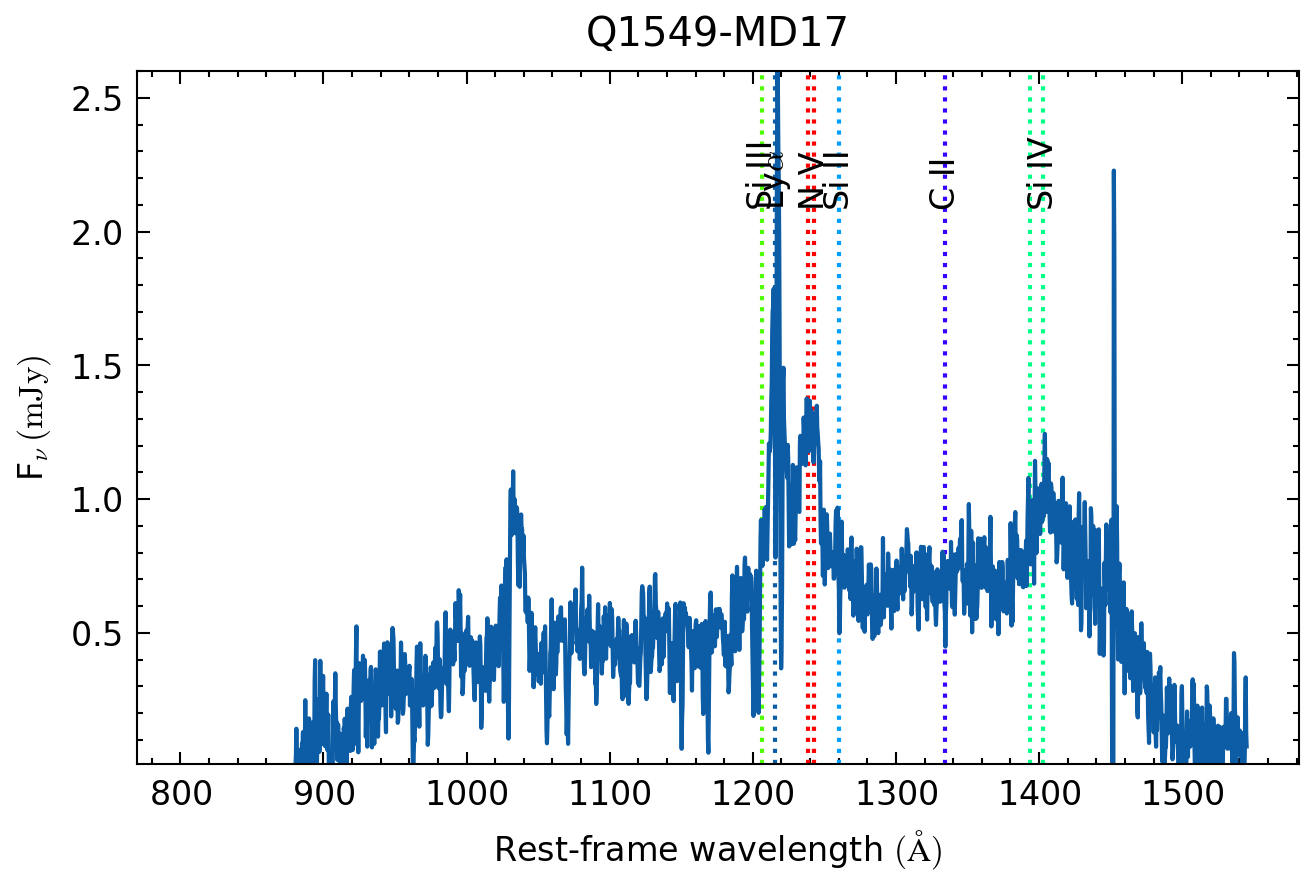

In [45]:
plt.style.use(["science",'no-latex'])
plt.rcParams.update({
    "font.family": "dejavu sans",   # specify font family here
    "font.serif": ["Times"],  # specify font here
    "font.size":8,
"legend.fancybox":True})
rng1 = np.random.default_rng(122807528840384100672342137672332424406)
Yunit = r"F$_{\nu}\,\rm (mJy)$"
fig, ax = plt.subplots(figsize=(5,3),dpi=300)

x = spec_axis
xlow=x[0]/(1+redshift)
xhigh=x[-1]/(1+redshift)
keys=lines.keys()
colors=matplotlib.cm.hsv(np.arange(len(keys))/len(keys))


# redshift of the CGM being probed. QSO sight-line
zcgm = redshift
#zcgm=redshift
rlinec= (zcgm+1)/(redshift+1)
yup=np.max(flux_1d)
#Marking the important lines
ax.axvline(rlinec*1215.67,ls=":")
ax.text(rlinec*1215.67, 0.8*yup,r"Ly$\alpha$", rotation=90,verticalalignment='bottom',horizontalalignment='center')
mask=np.full(len(x),False)

ax.set_ylim(1e-2, yup)
#ax.set_xlim([xlow,xhigh])


dlam=7.5/2800
lines={ 'N V':[1238.821,1242.804], 'C IV':[1548.202,1550.774], "Si III":[1206.5],"Si IV":[1393.76,1402.77],"Si II":[1260.42],"C II":[1334.53], 'He II':[1640.4]}
keys=lines.keys()
for ind,key in enumerate(keys):
    for line in lines[key]:
        if line < xhigh and line > xlow:
            ax.axvline(rlinec*line,ls=":",c=colors[ind])
#            masktmp = (x.value < ((1+redshift)*line*(1+dlam))) & (x.value > ((1+redshift)*line*(1-dlam)))
#            mask= mask | masktmp
           # print(x[mask])
    if line < xhigh and line > xlow:
        ax.text(rlinec*line, 0.8*yup,key, rotation=90,verticalalignment='bottom',horizontalalignment='center')
#        ax.text(rlinec*line, 5e-1+10**(-4*rng1.random()),key,verticalalignment='bottom',horizontalalignment='center',fontsize=10)


ax.plot(x/(1+redshift), flux_1d, label = "Average Brightness")
#ax.fill_between(x.value/(1+redshift), spec.value - sigma, spec.value + sigma, color='cyan', alpha=0.2, label='1-sigma region')
#ax.plot(x[~mask]/(1+redshift), 1e4*sigma[~mask], label = "Std.dev.")

#sfeii=5e-4
#ax.plot(rlinec*wavemodel,fluxmodel*sfeii,color="m",label="Fe II")
#ax.plot(rlinec*wavemodel,fluxmodel*sfeii,color="m",label="Fe II")

#ax.legend()
ax.set_xlabel(r"Rest-frame wavelength $(\rm \AA)$")
ax.set_ylabel(Yunit)
ax.set_title("{}-{}".format(field,psname))

#ax.set_yscale("log")
fig.savefig(subdapath+"/spec/lris_fig.pdf")

In [32]:

regionfile="/scr/ccs/mosfire_redux"
KBSSpath="/disk/bifrost/yuanze/KBSS"
#cubename="Q1549"
#sourcename="BX101"
#redshift=2.3806
#datapath=KBSSpath+"/"+cubename+"/"+sourcename
code="msfr1"
try:
    mos2dH = fits.open(subdapath+"/mosfire/{}_{}_H_{}_flx.fits".format(cubename.lower(),code,psname))
    mos2dHsig = fits.open(subdapath+"/mosfire/{}_{}_H_{}_flx.sig.fits".format(cubename.lower(),code,psname))
#    mos1dH = fits.open(subdapath+"/mosfire/{}_msfr1_H_{}_1d.fits".format(cubename.lower(),psname))
    ps = mos2dH[0].header["PSCALE"]
except:
    print("no H band data")
    mos2dH = None
    mos1dH = None

try:
    mos2dK = fits.open(subdapath+"/mosfire/{}_{}_K_{}_flx.fits".format(cubename.lower(),code,psname))
    mos2dKsig = fits.open(subdapath+"/mosfire/{}_{}_K_{}_flx.sig.fits".format(cubename.lower(),code,psname))
    mos1dK = fits.open(subdapath+"/mosfire/{}_{}_K_{}_1d.fits".format(cubename.lower(),code,psname))
except:
    print("no K band data")
    mos2dK = None
    mos1dK = None

try:
    mos2dJ = fits.open(subdapath+"/mosfire/{}_{}_J_{}_flx.fits".format(cubename.upper(),code,psname))
    #mos2dHsig = fits.open("/disk/bifrost/yuanze/KBSS/Q1549/BX101/mosfire/Q1549close1_H_BX101_flx.sig.fits")
#    mos1dJ = fits.open(subdapath+"/mosfire/{}msfr3_J_{}_1d.fits".format(cubename.lower(),psname))
except:
    print("no J band data")
    mos2dJ = None
    mos1dJ = None

no H band data
no K band data
no J band data
